In [371]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import shap
import os

In [141]:
season_mapping = {
    1: 'Winter', 2: 'Winter', 12: 'Winter', 
    3: 'Spring', 4: 'Spring', 5: 'Spring', 
    6: 'Summer', 7: 'Summer', 8: 'Summer', 
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

month_mapping = {
    1: 'January', 2: 'February', 3: 'March',
    4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September',
    10: 'October', 11: 'November', 12: 'December'
}

In [373]:
# state = 'Michigan'

def create_frame(state, month_season, stat, target_column):
    weather = pd.read_csv(f'collated_data/{state}.csv')[['Date','cdd','hdd','tavg']]
    weather['Date'] = pd.to_datetime(weather['Date'].astype(str), format='%Y%m')
    weather['Year'] = weather['Date'].dt.year
    if month_season == 'Month':
        mapping = month_mapping
    else:
        mapping = season_mapping
    
    weather[month_season] = weather['Date'].dt.month.map(mapping)
    weather_agg = weather.groupby(['Year',month_season])[stat].mean().reset_index()
    weather_agg = weather.groupby(['Year',month_season])[stat].mean().reset_index()
    weather_pivot = weather_agg.pivot(index='Year', columns=month_season, values=stat)
    weather_pivot.columns = ['_'.join(col).strip() for col in weather_pivot.columns.values]
    energy = pd.read_csv(f'power_consumption/{state}.csv')
    energy.set_index('Year', inplace=True)
    weathergy = pd.concat([weather_pivot, energy[['Residential sector', 'Commercial sector', 
                                                  'Industrial sector', 'Transportation sector', 'Total consumption']]], axis=1)
    
    X = weathergy.drop(columns=['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption'])
    y = weathergy[['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption']]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model = XGBRegressor(random_state=43)
    
    model.fit(X, y[target_column])
    feature_importances = model.feature_importances_

    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=True)

    return importance_df, state, target_column
        # features = X.columns
        # plt.figure(figsize=(12,6))
        # # plt.barh(features, rf_feature_importances)
        # plt.barh(importance_df['Feature'], importance_df['Importance'])
        # plt.title(f"Feature Importance for {target_column}")
        # plt.xlabel("Importance")
        # plt.ylabel("Features")
        # plt.show()

results = []
for target_column in ['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption']:
    for state in os.listdir('collated_data'):
        state = state.replace('.csv', '')
        importance_df, state, target_column = create_frame(state, 'Season', ['cdd', 'hdd'], target_column)
        for index, row in importance_df.iterrows():
            results.append({
                "State": state,
                "Target Column": target_column,
                "Feature": row['Feature'],
                "Importance": row['Importance']
            })
results_df = pd.DataFrame(results)
results_df.to_csv('feature_importance_results.csv', index=False)

results_df.head()

,State,Target Column,Feature,Importance
0,Alabama,Residential sector,hdd_Summer,0.000000
1,Alabama,Residential sector,cdd_Spring,0.016844
2,Alabama,Residential sector,hdd_Fall,0.018814
3,Alabama,Residential sector,cdd_Fall,0.025801
4,Alabama,Residential sector,cdd_Summer,0.107286


In [375]:
importance_df

,Feature,Importance
3,cdd_Winter,0.000000
0,cdd_Fall,0.001524
4,hdd_Fall,0.020474
1,cdd_Spring,0.027328
2,cdd_Summer,0.031821
5,hdd_Spring,0.167876
6,hdd_Summer,0.311184
7,hdd_Winter,0.439793


For Michigan, Spring contributes the most to the total consumption.


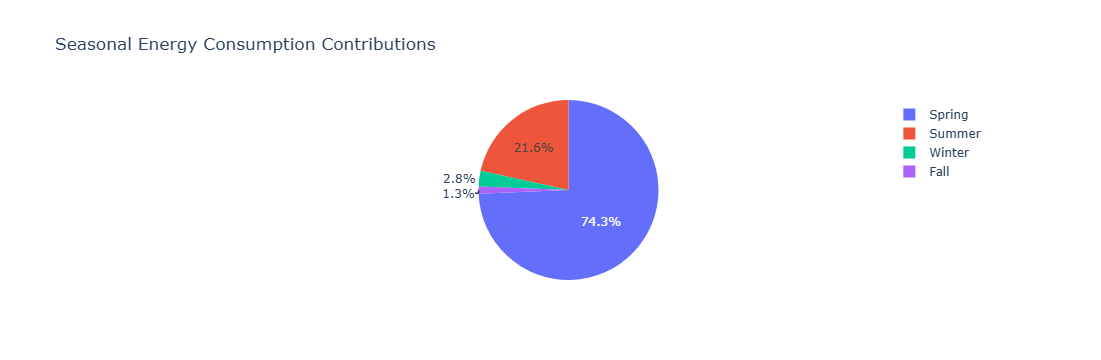

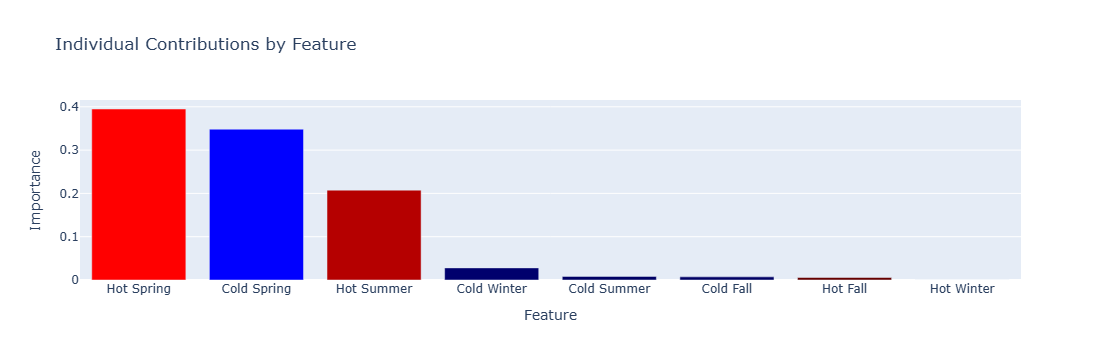

In [365]:
def aggregate_and_rank(df, state, target_column):
    season_map = {
        "Winter": ["cdd_Winter", "hdd_Winter"],
        "Spring": ["cdd_Spring", "hdd_Spring"],
        "Summer": ["cdd_Summer", "hdd_Summer"],
        "Fall": ["cdd_Fall", "hdd_Fall"]
    }
    season_totals = {season: df[df["Feature"].isin(features)]["Importance"].sum() for season, features in season_map.items()}
    season_df = pd.DataFrame(list(season_totals.items()), columns=["Season", "Contribution"]).sort_values(by="Contribution", ascending=False)


    top_contributor = season_df.iloc[0]
    second_contributor = season_df.iloc[1] if len(season_df) > 1 else None

    co_dominance_threshold = 0.05 

    if second_contributor is not None:
        diff = top_contributor["Contribution"] - second_contributor["Contribution"]

        if diff <= co_dominance_threshold:
            print(f"For {state}, {top_contributor['Season']} and {second_contributor['Season']} contribute the most")
        else:
            print(f"For {state}, {top_contributor['Season']} contributes the most to the {target_column.lower()}.")

    else:
        print(f"For {state}, {top_contributor['Season']} is the only major contributor to the {target_column.lower()}.")

    fig1 = px.pie(season_df, names='Season', values='Contribution', title="Seasonal Energy Consumption Contributions")

    df["Category"] = df["Feature"].apply(lambda x: "Hot " + x.split("_")[1] if "cdd" in x else "Cold " + x.split("_")[1])

    min_importance_blue = df[df['Category'].str.startswith('Cold')]['Importance'].min()
    max_importance_blue = df[df['Category'].str.startswith('Cold')]['Importance'].max()
    min_importance_red = df[df['Category'].str.startswith('Hot')]['Importance'].min()
    max_importance_red = df[df['Category'].str.startswith('Hot')]['Importance'].max()
    min_color_value = 100
    
    df["Color"] = df.apply(
        lambda row: f"rgb({min(255,int((row['Importance'] - min_importance_red) / (max_importance_red - min_importance_red) * (255 - min_color_value)
                               + min_color_value))}, 0, 0)" if "Hot" in row["Category"] 
        else f"rgb(0, 0, {min(255,int((row['Importance'] - min_importance_blue) / (max_importance_blue - min_importance_blue) * (255 - min_color_value)
                              + min_color_value))})", axis=1
    )
    
    df_sorted = df.sort_values(by="Importance", ascending=False)

    
    fig2 = go.Figure()

    # Add Hot features (Red gradient)
    fig2.add_trace(go.Bar(
        x=df_sorted["Category"],  # Feature names
        y=df_sorted["Importance"],  # Importance values
        # text=df_sorted["Category"],  # Show Category as text
        hoverinfo="text",  # Show category on hover
        marker=dict(
            color=df_sorted["Color"],  # Color based on importance and category
        )
    ))

    fig2.update_layout(
        title="Individual Contributions by Feature",
        xaxis_title="Feature",
        yaxis_title="Importance",
        showlegend=False
    )

    # Show both plots
    fig1.show()
    fig2.show()

aggregate_and_rank(importance_df, state, target_column)